In [161]:
import warnings
warnings.filterwarnings("ignore")

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import scipy.stats as stats
import numpy as np
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from ISLP.models import (sklearn_sm,ModelSpec)
from sklearn.linear_model import GammaRegressor
from sklearn.model_selection import cross_validate,train_test_split
from sklearn import metrics


In [163]:


# data = pd.read_csv('autompg/autompg.data',sep='\s+',header = None)
# data.info()
# data.columns=["mpg","cylinders","displacement","horsepower","weight","acceleration","model_year","origin","car_name"]
# data["horsepower"][data["horsepower"]=="?"]
# for i in data:
#     data = data[~pd.isna(data[i])]
# data.info()

data = pd.read_csv('autompg/autompg.data',sep='\s+',header = None)
data.info()
data.columns=["mpg","cylinders","displacement","horsepower","weight","acceleration","model_year","origin","car_name"]
data["horsepower"][data["horsepower"]=="?"]
for i in data:
    data = data[(data[i]!="?") & (~pd.isna(data[i]) & (data[i]!=0))]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       398 non-null    float64
 1   1       398 non-null    int64  
 2   2       398 non-null    float64
 3   3       398 non-null    object 
 4   4       398 non-null    float64
 5   5       398 non-null    float64
 6   6       398 non-null    int64  
 7   7       398 non-null    int64  
 8   8       398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    object 
 4   weight        392 non-null    float64
 5   acceleration  39

In [164]:


data['horsepower'] = data['horsepower'].astype(float).astype(int)
data['cylinders'] = data['cylinders'].astype(int)
data['origin'] = data['origin'].astype(int)



data['origin_cat1'] = (data['origin'] == 1).astype(int)
data['origin_cat2'] = (data['origin'] == 2).astype(int)

data.car_name = data.car_name.astype('string')
data['car_brand'] = data['car_name']
for i in range(0,len(data.car_brand)):
    data.car_brand.iloc[i]=(data.car_brand.iloc[i].split(' ', 1)[0])


data.loc[data.car_brand == "vokswagen",'car_brand'] = 'volkswagen'
data.loc[data.car_brand == "vw",'car_brand'] = 'volkswagen'
data['car_brand'] = data['car_brand'].astype('category')
data= sm.add_constant(data)

counts = []
for i in data["car_brand"].cat.categories:
    counts.append(sum(data.car_brand == i))
brand_count = list(zip(counts,data["car_brand"].cat.categories))

brand_count.sort(key = lambda x : -x[0])
print(brand_count)


[(48, 'ford'), (43, 'chevrolet'), (31, 'plymouth'), (28, 'dodge'), (27, 'amc'), (25, 'toyota'), (23, 'datsun'), (22, 'volkswagen'), (17, 'buick'), (16, 'pontiac'), (13, 'honda'), (11, 'mercury'), (10, 'mazda'), (10, 'oldsmobile'), (8, 'fiat'), (8, 'peugeot'), (7, 'audi'), (6, 'chrysler'), (6, 'volvo'), (4, 'opel'), (4, 'saab'), (4, 'subaru'), (3, 'chevy'), (3, 'renault'), (2, 'bmw'), (2, 'cadillac'), (2, 'maxda'), (2, 'mercedes-benz'), (1, 'capri'), (1, 'chevroelt'), (1, 'hi'), (1, 'mercedes'), (1, 'nissan'), (1, 'toyouta'), (1, 'triumph')]


In [165]:
data['log_mpg'] = np.log(data['mpg'])
data['log_dis'] = np.log(data['displacement'])
data['log_hp'] = np.log(data['horsepower'])
data['log_weight'] = np.log(data['weight'])
data['log_acc'] = np.log(data['acceleration'])
data['log_cyl'] = np.log(data['cylinders'])

data['in_mpg'] = 1/(data['mpg'])
data['in_dis'] = 1/(data['displacement'])
data['in_hp'] = 1/(data['horsepower'])
data['in_weight'] = 1/(data['weight'])
data['in_acc'] = 1/(data['acceleration'])
data['in_cyl'] = 1/(data['cylinders'])



In [166]:
mpg = data.mpg

shape = 9.046845191319962,scale = 2.5916126419232013
KstestResult(statistic=0.05801499380561037, pvalue=0.1373676112852017, statistic_location=18.1, statistic_sign=1)
mu = 23.445918367346938,lambda = 193.38316687500895
KstestResult(statistic=0.06397542753705121, pvalue=0.07734331829489305, statistic_location=26.0, statistic_sign=-1)


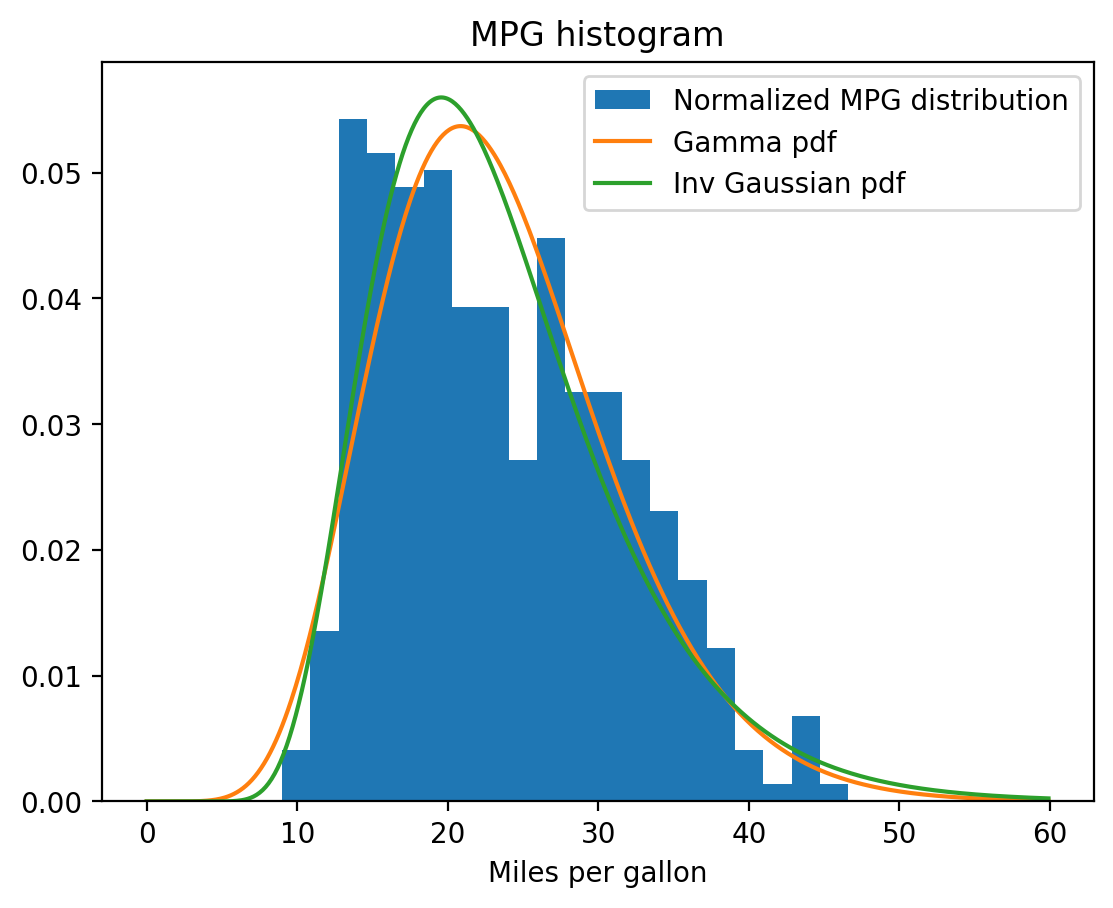

In [190]:
#Braizome mpg histograma
fig, ax = plt.subplots(dpi = 200)
ax.hist(mpg, bins = 20,density = True, label = "Normalized MPG distribution")


mean = np.mean(mpg)
variance = np.var(mpg)

shape = np.mean(mpg)**2/np.var(mpg)
scale = np.var(mpg)/np.mean(mpg)
print(f"shape = {shape},scale = {scale}")
x = np.arange(0,60,0.1)

pdf_values = stats.gamma.pdf(x,a = shape, scale = scale)
ax.plot(x,pdf_values, label='Gamma pdf')
ax.set_xlabel("Miles per gallon")
ax.set_title("MPG histogram")
ax.legend()
fig.savefig("MPG histogram",dpi = 200)
print(scipy.stats.kstest(mpg, lambda x:stats.gamma.cdf(x,a = shape, scale = scale)))

def estimate_inverse_gaussian_params(data):
    mu_hat = np.mean(data)
    harmonic_mean = len(data) / np.sum(1.0 / data)
    lambda_hat = 1.0 / (1.0 / harmonic_mean - 1.0 / mu_hat)
    return mu_hat, lambda_hat

nu, lam = estimate_inverse_gaussian_params(mpg)

pdf_values = stats.invgauss.pdf(x, mu = nu/lam, loc = 0, scale = lam)

ax.plot(x,pdf_values, label='Inv Gaussian pdf')
ax.set_xlabel("Miles per gallon")
ax.set_title("MPG histogram")
ax.legend()
fig.savefig("MPG histogram",dpi = 200)

print(f"niu = {nu},lambda = {lam}")
print(scipy.stats.kstest(mpg, lambda x:stats.invgauss.cdf(x, mu = nu/lam, loc = 0, scale = lam)))



Estimated mu: 23.445918367346938, Estimated lambda: 193.38316687500895


AttributeError: module 'scipy.stats' has no attribute 'InverseGauss'

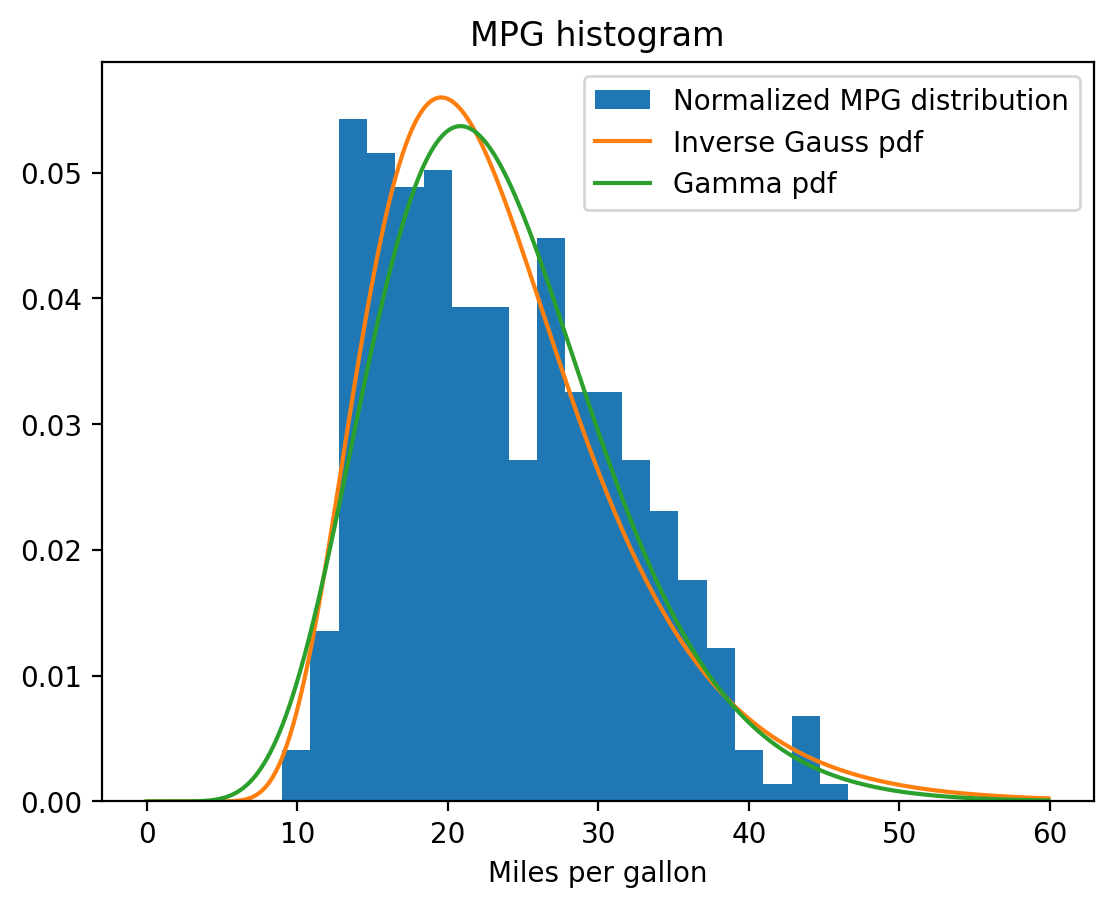

In [187]:

def estimate_inverse_gaussian_params(data):
    mu_hat = np.mean(data)
    harmonic_mean = len(data) / np.sum(1.0 / data)
    lambda_hat = 1.0 / (1.0 / harmonic_mean - 1.0 / mu_hat)
    return mu_hat, lambda_hat
#Braizome mpg histograma
fig, ax = plt.subplots(dpi = 200)

mu_hat, lambda_hat = estimate_inverse_gaussian_params(mpg)
print(f"Estimated mu: {mu_hat}, Estimated lambda: {lambda_hat}")
pdf_values = stats.invgauss.pdf(x, mu = mu_hat/lambda_hat, loc = 0, scale = lambda_hat)
ax.hist(mpg, bins = 20,density = True, label = "Normalized MPG distribution")
ax.plot(x,pdf_values, label='Inverse Gauss pdf')
pdf_values = stats.gamma.pdf(x,a = shape, scale = scale)
ax.plot(x,pdf_values, label='Gamma pdf')
ax.set_xlabel("Miles per gallon")
ax.set_title("MPG histogram")
ax.legend()
fig.savefig("MPG histogram",dpi = 200)
print(scipy.stats.kstest(mpg, lambda x:stats.inversega(x,a = shape, scale = scale)))

In [ ]:

print(scipy.stats.kstest(mpg, lambda x:stats.invgauss.cdf(x, scale = mu_est, mu=lambda_est)))

KstestResult(statistic=0.5371272903870361, pvalue=2.7657078854251523e-106, statistic_location=38.1, statistic_sign=1)


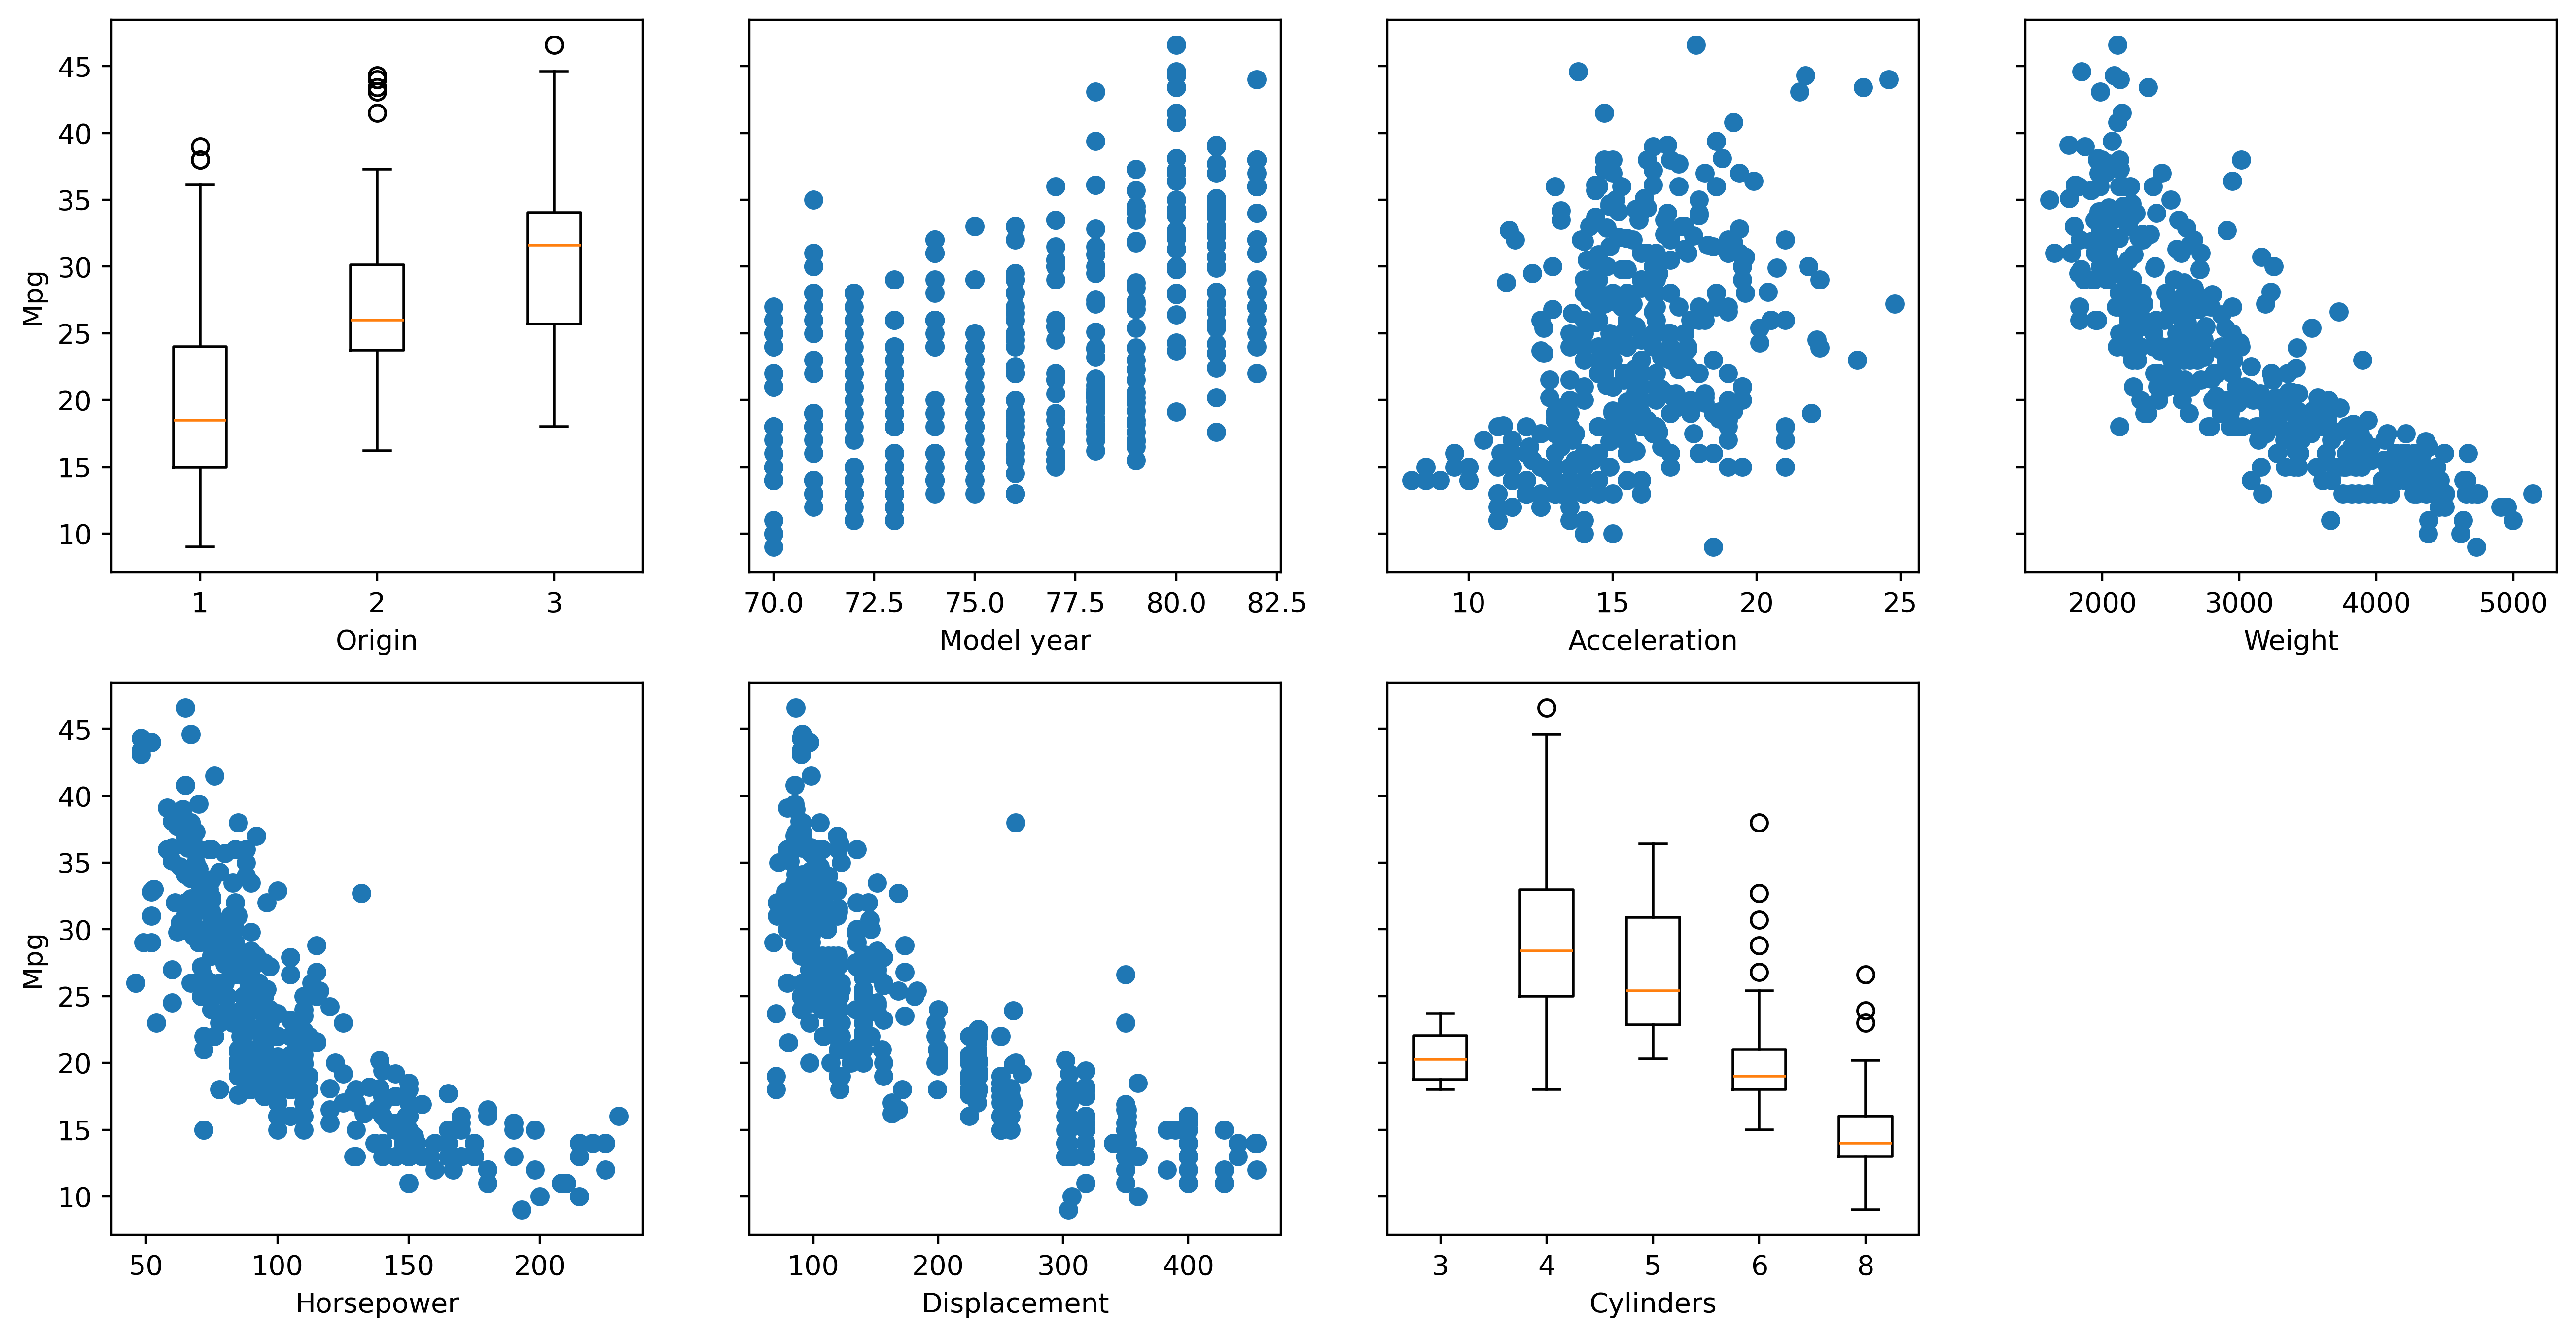

In [14]:
fig, axes = plt.subplots(figsize = (16,8),nrows = 2, ncols = 4,dpi=400, sharey=True)
scatter_columns = ['cylinders','displacement','horsepower','weight','acceleration','model_year','origin']

for x in range(0,2):
    for y in range(0,4):
        if scatter_columns:
            if (scatter_columns[-1] == 'origin'):
                scatter_columns.pop()
            elif (scatter_columns[-1] == 'cylinders'):
                scatter_columns.pop()

            else:
                column=scatter_columns.pop()
                axes[x,y].scatter(data[column],data['mpg'],)
                title = column.capitalize().replace("_"," ")
                axes[x,y].set_xlabel(title)


axes[1, 3].set_visible(False)
axes[0,0].boxplot([data['mpg'][data['origin']==1],
                   data['mpg'][data['origin']==2],
                   data['mpg'][data['origin']==3]])
axes[0,0].set_xticks([1,2,3])
axes[0,0].set_xlabel("Origin")
axes[0,0].set_ylabel("Mpg")

axes[1,2].boxplot([data['mpg'][data['cylinders']==3],
              data['mpg'][data['cylinders']==4],
              data['mpg'][data['cylinders']==5],
              data['mpg'][data['cylinders']==6],
            data['mpg'][data['cylinders']==8]])
axes[1,2].set_xticklabels([3,4,5,6,8])
axes[1,2].set_xlabel("Cylinders")
axes[1,0].set_ylabel("Mpg")
fig.savefig("Scatter plots")



Text(0, 0.5, 'Mpg')

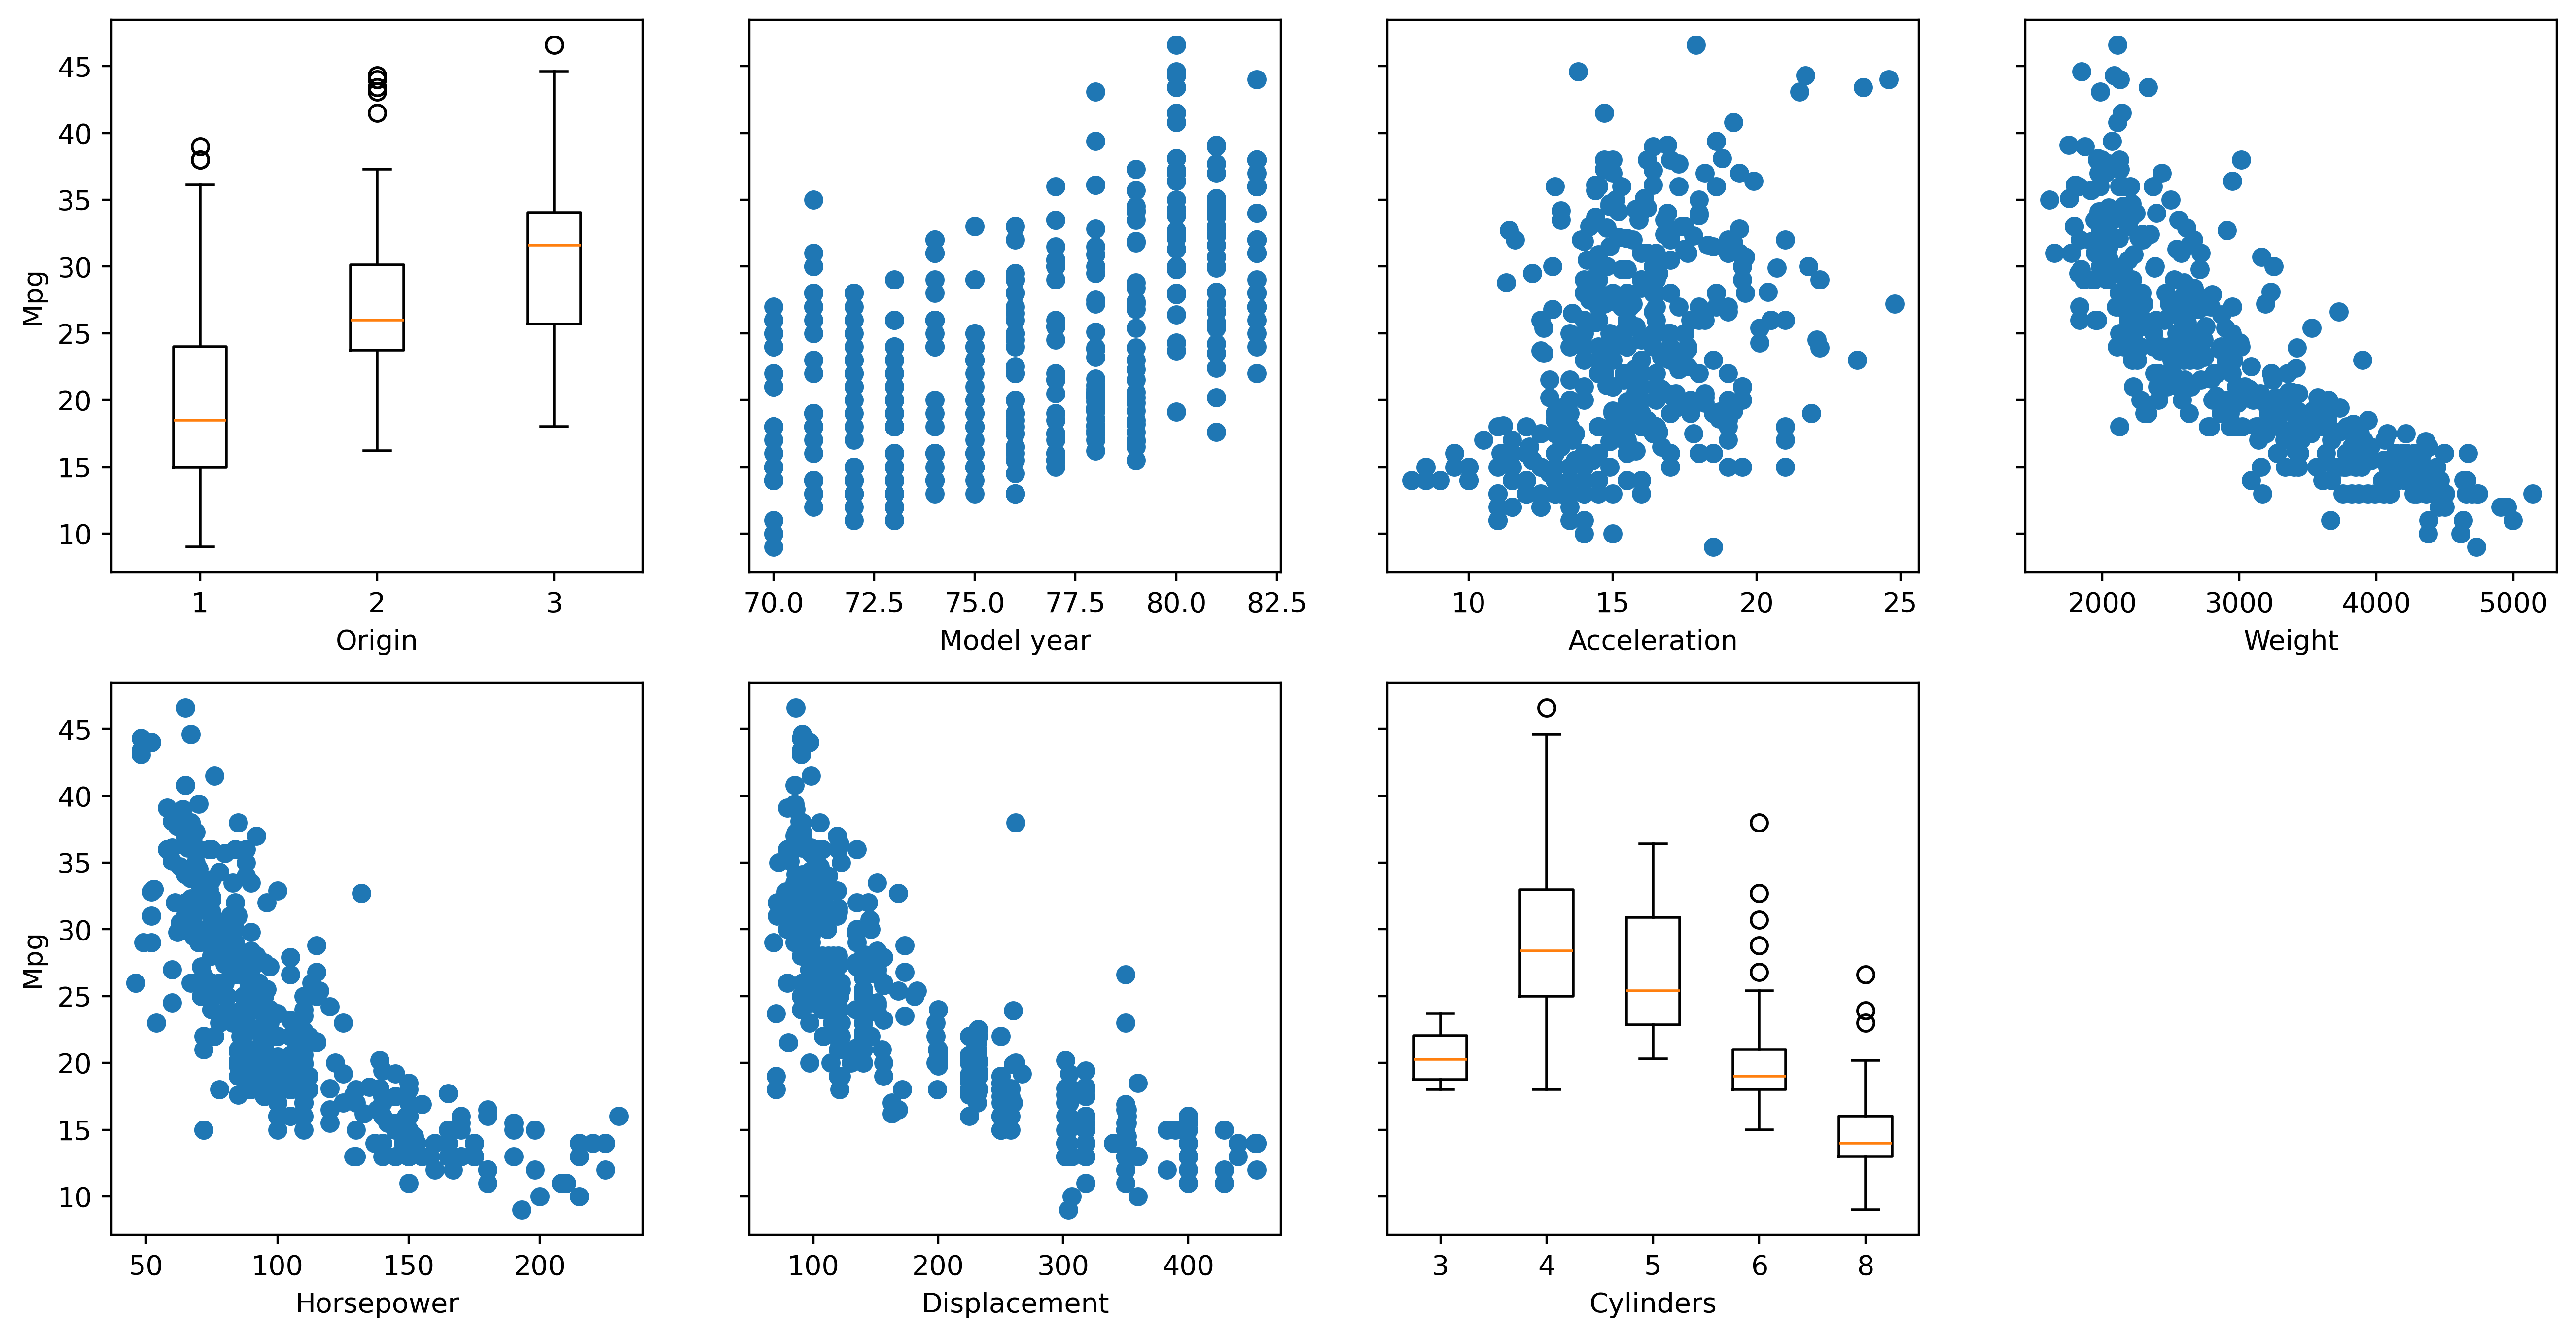

In [15]:
fig, axes = plt.subplots(figsize = (16,8),nrows = 2, ncols = 4,dpi=400, sharey=True)

scatter_columns = ['cylinders','displacement','horsepower','weight','acceleration','model_year','origin']

for x in range(0,2):
    for y in range(0,4):
        if scatter_columns:
            if (scatter_columns[-1] == 'origin'):
                scatter_columns.pop()
            elif (scatter_columns[-1] == 'cylinders'):
                scatter_columns.pop()

            else:
                column=scatter_columns.pop()
                axes[x,y].scatter(data[column],data['mpg'],)
                title = column.capitalize().replace("_"," ")
                axes[x,y].set_xlabel(title)


axes[1, 3].set_visible(False)
axes[0,0].boxplot([data['mpg'][data['origin']==1],
                   data['mpg'][data['origin']==2],
                   data['mpg'][data['origin']==3]])
axes[0,0].set_xticks([1,2,3])
axes[0,0].set_xlabel("Origin")
axes[0,0].set_ylabel("Mpg")

axes[1,2].boxplot([data['mpg'][data['cylinders']==3],
              data['mpg'][data['cylinders']==4],
              data['mpg'][data['cylinders']==5],
              data['mpg'][data['cylinders']==6],
            data['mpg'][data['cylinders']==8]])
axes[1,2].set_xticklabels([3,4,5,6,8])
axes[1,2].set_xlabel("Cylinders")
axes[1,0].set_ylabel("Mpg")



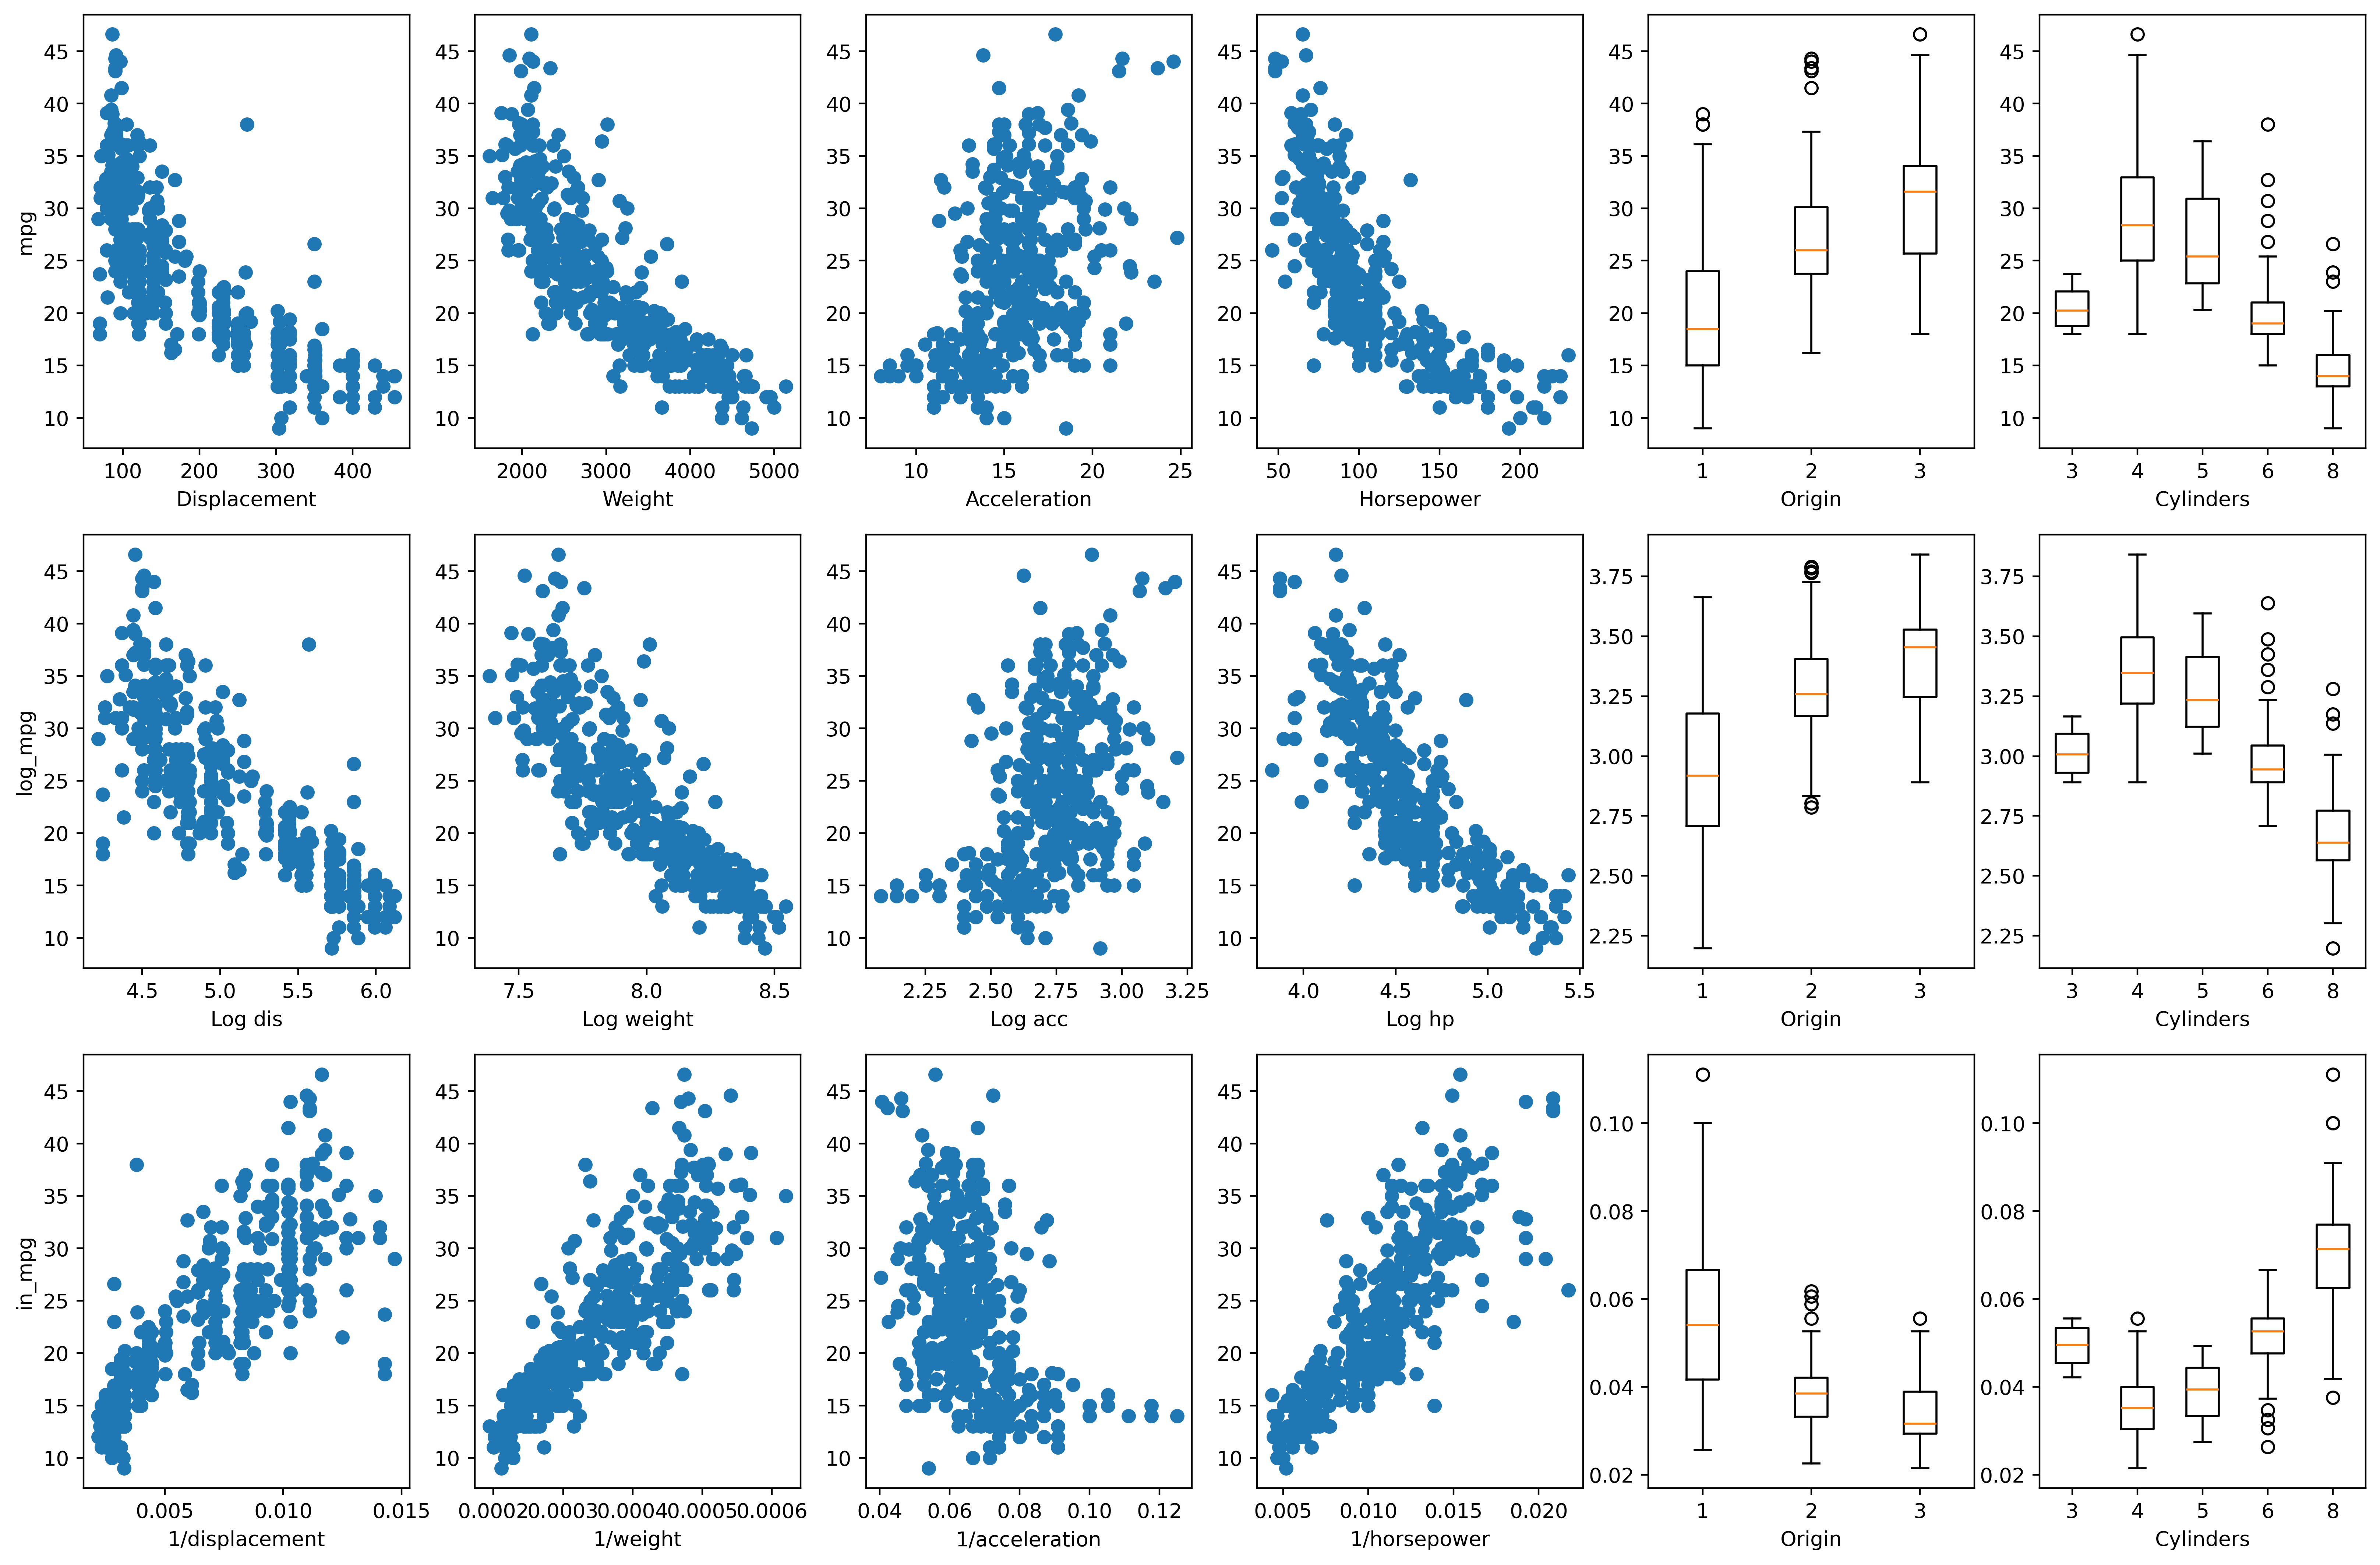

In [16]:
fig, axes = plt.subplots(figsize = (20,13),nrows = 3, ncols = 6,dpi=400)

scatter_columns = ['in_hp','in_acc','in_weight','in_dis','log_hp','log_acc','log_weight','log_dis','horsepower','acceleration','weight','displacement']
y_names = ['in_mpg','log_mpg','mpg']
for x in range(0,3):
    for y in range(0,4):
        if scatter_columns:
                column=scatter_columns.pop()
                axes[x,y].scatter(data[column],data['mpg'],)
                title = column.capitalize().replace("_"," ")
                # axes[x,y].set_title(title)
                axes[x,y].set_xlabel(title)
        axes[x,0].set_ylabel(y_names[-x-1])        
         
column_names = ['horsepower','acceleration','weight','displacement']
for i in range(0,4):
  axes[2,i].set_xlabel(f"1/{column_names.pop()}")


for i in range(0,3):
  column = y_names.pop()
  axes[i,5].boxplot([data[column][data['cylinders']==3],
                data[column][data['cylinders']==4],
                data[column][data['cylinders']==5],
                data[column][data['cylinders']==6],
              data[column][data['cylinders']==8]])
  axes[i,5].set_xticklabels([3,4,5,6,8])
  axes[i,5].set_xlabel("Cylinders")

y_names = ['in_mpg','log_mpg','mpg']
for i in range(0,3):
  column = y_names.pop()
  axes[i,4].boxplot([data[column][data['origin']==1],
                    data[column][data['origin']==2],
                    data[column][data['origin']==3]])
  axes[i,4].set_xticks([1,2,3])
  axes[i,4].set_xlabel("Origin")




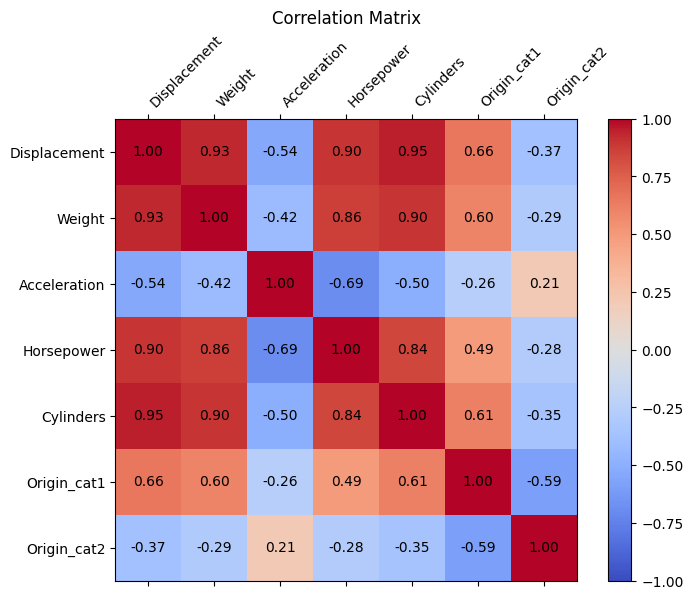

In [19]:
columns = ['displacement','weight',"acceleration",'horsepower','cylinders','origin_cat1','origin_cat2']
dataframe = data[columns]
corr_matrix = dataframe.corr()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the correlation matrix as a heatmap
cax = ax.matshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Add color bar
cbar = fig.colorbar(cax)

# Set ticks and labels
ticks = range(len(corr_matrix.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels([i.capitalize() for i in corr_matrix.columns], rotation=45, ha='left')
ax.set_yticklabels([i.capitalize() for i in corr_matrix.columns])

# Add color lines
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        ax.text(i, j, f"{corr_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black')

plt.title("Correlation Matrix")
plt.show()

In [29]:
X_log =  sm.add_constant(data[['log_weight','log_acc','origin_cat1','origin_cat2']])
X_inv =  sm.add_constant(data[['in_weight','in_acc','origin_cat1','origin_cat2']])
X_iden = sm.add_constant(data[['weight','acceleration','origin_cat1','origin_cat2']])
Y = (data['mpg'])

log_link = sm.families.links.Log()
iden_link = sm.families.links.identity()
inv_link = sm.families.links.inverse_power()

In [100]:
gamma_log = sm.GLM(Y,X_log,sm.families.Gamma(log_link)).fit()
gamma_iden = sm.GLM(Y,X_iden,sm.families.Gamma(iden_link)).fit()
gamma_inv = sm.GLM(Y,X_inv,sm.families.Gamma(inv_link)).fit()

print(gamma_log.summary(),
gamma_iden.summary(),
gamma_inv.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    mpg   No. Observations:                  392
Model:                            GLM   Df Residuals:                      387
Model Family:                   Gamma   Df Model:                            4
Link Function:                    Log   Scale:                        0.027045
Method:                          IRLS   Log-Likelihood:                -1055.7
Date:                Sun, 24 Mar 2024   Deviance:                       10.150
Time:                        12:29:05   Pearson chi2:                     10.5
No. Iterations:                    10   Pseudo R-squ. (CS):             0.9597
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.1627      0.386     26.312      

In [101]:
ig_log = sm.GLM(Y,X_log,sm.families.InverseGaussian(log_link)).fit()
ig_iden = sm.GLM(Y,X_iden,sm.families.InverseGaussian(iden_link)).fit()
ig_inv = sm.GLM(Y,X_inv,sm.families.InverseGaussian(inv_link)).fit()
print(ig_log.summary(),ig_iden.summary(),ig_inv.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    mpg   No. Observations:                  392
Model:                            GLM   Df Residuals:                      387
Model Family:         InverseGaussian   Df Model:                            4
Link Function:                    Log   Scale:                       0.0011734
Method:                          IRLS   Log-Likelihood:                -1049.5
Date:                Sun, 24 Mar 2024   Deviance:                      0.44602
Time:                        12:29:08   Pearson chi2:                    0.454
No. Iterations:                    12   Pseudo R-squ. (CS):             0.9678
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.3214      0.378     27.330      

#Cross validation

In [131]:


data_shuffled = data.sample(frac=1).reset_index(drop=True)
np.random.seed(3)
folds = np.array_split(data_shuffled, 10,)

#Gamma log
Rsq =  []
MSE_list = []
for i in range(10):
    test = folds[i]
    train = pd.concat([folds[j] for j in range(10) if j != i])
    X_train = sm.add_constant(train[['log_weight','log_acc','origin_cat1','origin_cat2']])
    X_test = sm.add_constant(test[['log_weight','log_acc','origin_cat1','origin_cat2']])
    Y_train = train['mpg']
    Y_test = test['mpg']
    model = sm.GLM(Y_train,X_train,sm.families.Gamma(log_link)).fit()

    predicted = model.predict(X_test)
    actual = Y_test

    MSE = np.mean((predicted - actual)**2)
    RSS = sum((predicted - actual)**2)
    SST=np.sum((actual-np.mean(actual))**2)
    MSE_list.append(MSE)
    Rsq.append(1-(RSS/SST)) 
   
    del X_train,X_test,Y_test,Y_train
MSE_gamma_log = np.mean(MSE_list)
Rsq_gamma_log = np.mean(Rsq) 

#Gamma identity
MSE_list = []
Rsq =  []
for i in range(10):
    test = folds[i]
    train = pd.concat([folds[j] for j in range(10) if j != i])
    X_train = sm.add_constant(train[['weight','acceleration','origin_cat1','origin_cat2']])
    X_test = sm.add_constant(test[['weight','acceleration','origin_cat1','origin_cat2']])
    Y_train = train['mpg']
    Y_test = test['mpg']
    model = sm.GLM(Y_train,X_train,sm.families.Gamma(iden_link)).fit()

    predicted = model.predict(X_test)
    actual = Y_test

    MSE = np.mean((predicted - actual)**2)
    RSS = sum((predicted - actual)**2)
    SST=np.sum((actual-np.mean(actual))**2)
    MSE_list.append(MSE)
    Rsq.append(1-(RSS/SST)) 

    del X_train,X_test,Y_test,Y_train
MSE_gamma_iden = np.mean(MSE_list)
Rsq_gamma_iden = np.mean(Rsq) 

#Gamma inverse
Rsq =  []
MSE_list = []
for i in range(10):
    test = folds[i]
    train = pd.concat([folds[j] for j in range(10) if j != i])
    X_train = sm.add_constant(train[['in_weight','in_acc','origin_cat1','origin_cat2']])
    X_test = sm.add_constant(test[['in_weight','in_acc','origin_cat1','origin_cat2']])
    Y_train = train['mpg']
    Y_test = test['mpg']
    model = sm.GLM(Y_train,X_train,sm.families.Gamma(inv_link)).fit()

    predicted = model.predict(X_test)
    actual = Y_test

    MSE = np.mean((predicted - actual)**2)
    RSS = sum((predicted - actual)**2)
    SST=np.sum((actual-np.mean(actual))**2)
    MSE_list.append(MSE)
    Rsq.append(1-(RSS/SST))   
    del X_train,X_test,Y_test,Y_train
MSE_gamma_inv = np.mean(MSE_list)
Rsq_gamma_inv = np.mean(Rsq) 

#Inverse gaussian log
MSE_list = []
Rsq =  []
for i in range(10):
    test = folds[i]
    train = pd.concat([folds[j] for j in range(10) if j != i])
    X_train = sm.add_constant(train[['log_weight','log_acc','origin_cat1','origin_cat2']])
    X_test = sm.add_constant(test[['log_weight','log_acc','origin_cat1','origin_cat2']])
    Y_train = train['mpg']
    Y_test = test['mpg']
    model = sm.GLM(Y_train,X_train,sm.families.InverseGaussian(log_link)).fit()

    predicted = model.predict(X_test)
    actual = Y_test

    MSE = np.mean((predicted - actual)**2)
    RSS = sum((predicted - actual)**2)
    SST=np.sum((actual-np.mean(actual))**2)
    MSE_list.append(MSE)
    Rsq.append(1-(RSS/SST)) 

    del X_train,X_test,Y_test,Y_train
Rsq_ig_log = np.mean(Rsq) 
MSE_ig_log = np.mean(MSE_list)




#Inverse gaussian iden
MSE_list = []
Rsq =  []
for i in range(10):
    test = folds[i]
    train = pd.concat([folds[j] for j in range(10) if j != i])
    X_train = sm.add_constant(train[['weight','acceleration','origin_cat1','origin_cat2']])
    X_test = sm.add_constant(test[['weight','acceleration','origin_cat1','origin_cat2']])
    Y_train = train['mpg']
    Y_test = test['mpg']
    model = sm.GLM(Y_train,X_train,sm.families.InverseGaussian(iden_link)).fit()

    predicted = model.predict(X_test)
    actual = Y_test
    MSE = np.mean((predicted - actual)**2)
    RSS = sum((predicted - actual)**2)
    SST=np.sum((actual-np.mean(actual))**2)
    MSE_list.append(MSE)
    Rsq.append(1-(RSS/SST)) 
    del X_train,X_test,Y_test,Y_train
MSE_ig_iden = np.mean(MSE_list)
Rsq_ig_iden = np.mean(Rsq) 

#Inverse gaussian inverse
MSE_list = []
Rsq =  []
for i in range(10):
    test = folds[i]
    train = pd.concat([folds[j] for j in range(10) if j != i])
    X_train = sm.add_constant(train[['in_weight','in_acc','origin_cat1','origin_cat2']])
    X_test = sm.add_constant(test[['in_weight','in_acc','origin_cat1','origin_cat2']])
    Y_train = train['mpg']
    Y_test = test['mpg']
    model = sm.GLM(Y_train,X_train,sm.families.InverseGaussian(inv_link)).fit()

    predicted = model.predict(X_test)
    actual = Y_test
    MSE = np.mean((predicted - actual)**2)
    RSS = sum((predicted - actual)**2)
    SST=np.sum((actual-np.mean(actual))**2)
    MSE_list.append(MSE)
    Rsq.append(1-(RSS/SST))  
    del X_train,X_test,Y_test,Y_train
MSE_ig_inv = np.mean(MSE_list)
Rsq_ig_inv = np.mean(Rsq) 








In [128]:
round(Rsq_ig_log,4)

-inf

In [132]:


model_comparison = pd.DataFrame({"AIC" : [gamma_log.aic,gamma_iden.aic,gamma_inv.aic,ig_log.aic,ig_iden.aic,ig_inv.aic],
                                 "CV MSE" : [MSE_gamma_log,MSE_gamma_iden,MSE_gamma_inv,MSE_ig_log,MSE_ig_iden,MSE_ig_inv],
                                 "Rsq" : [Rsq_gamma_log,Rsq_gamma_iden,Rsq_gamma_inv,Rsq_ig_log,Rsq_ig_iden,Rsq_ig_inv]
                                 }, index = ["Gamma link=log","Gamma link=identity","Gamma link=inverse","Inverse Gaussian link=log","Inverse Gaussian link=identity","Inverse Gaussian link=inverse"])
model_comparison

,AIC,CV MSE,Rsq
Gamma link=log,2121.375234,17.917912,0.702660
Gamma link=identity,2157.906760,18.557387,0.690709
Gamma link=inverse,2240.048840,25.577077,0.578117
Inverse Gaussian link=log,2109.014004,18.018867,0.700503
Inverse Gaussian link=identity,2155.332045,18.977253,0.683648
Inverse Gaussian link=inverse,2225.684009,31.576425,0.478654


Text(0, 0.5, "Cook's distance")

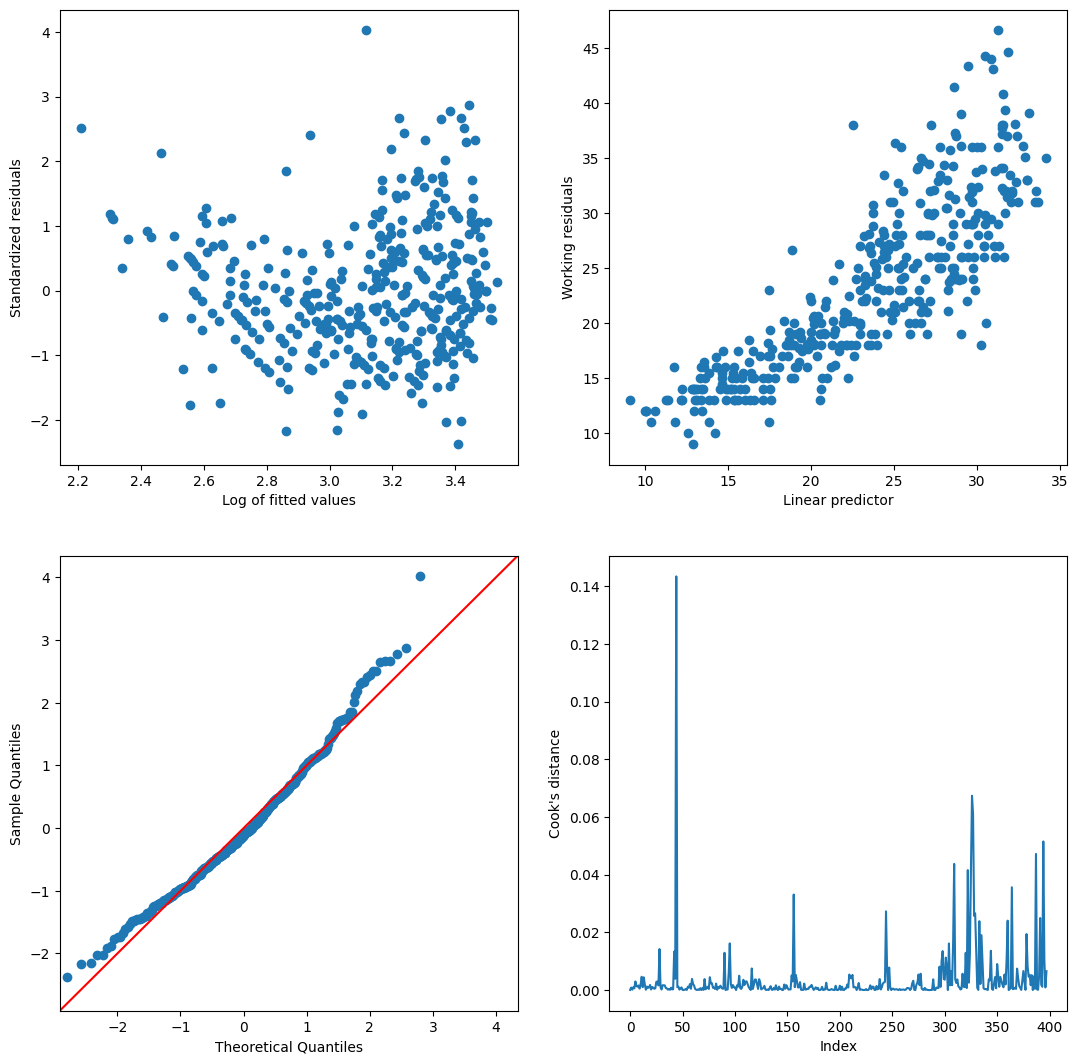

In [105]:
fig, axes = plt.subplots(figsize = (13,13),nrows=2,ncols=2)

#Standardized pearson residuals
stand_resid = (gamma_iden.resid_pearson - np.mean(gamma_iden.resid_pearson))/np.std(gamma_iden.resid_pearson)
axes[0,0].scatter(np.log(gamma_iden.predict()),stand_resid)
axes[0,0].set_xlabel("Log of fitted values")
axes[0,0].set_ylabel("Standardized residuals")

#Working residuals vs linear predictor
linear_predictor = (gamma_iden.params[0] + 
    gamma_iden.params[1]*data["weight"] +
    gamma_iden.params[2]*data["acceleration"] +
    gamma_iden.params[3]*data["origin_cat1"]+
    gamma_iden.params[4]*data["origin_cat2"])
axes[0,1].scatter(linear_predictor,gamma_iden.resid_working+linear_predictor)
axes[0,1].set_xlabel('Linear predictor')
axes[0,1].set_ylabel('Working residuals')

sm.qqplot(stand_resid,line = '45', ax = axes[1,0])
print("")
#Cook distance plot
cooks = gamma_iden.get_influence().cooks_distance
axes[1,1].plot(data.index,cooks[0])
axes[1,1].set_xlabel("Index")
axes[1,1].set_ylabel("Cook's distance")